In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

Problem Statement: Data with health care attributes and other personal details to classify if the person gets stroke or not based on their health atrributes

# Data Loading and Analysis


In [3]:
data = pd.read_csv('/workspaces/MLOps_HealthCare_Dataset/Simple_Deployment/healthcare-dataset.csv')
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


** Few Early Observations**

1. There are 3 binary featuers - {hypertension,heart_disease,stroke'}
2. There are 2 numerical Features which needs normalization('Bmi, glucose_level and age')
3. We need to convert categorical variables to numerical values.
4. Features are less. Need to create custom featurs.

In [5]:
#looking for some basic data discrepency
display(data.isnull().sum())
display(data.shape)

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

(5110, 12)

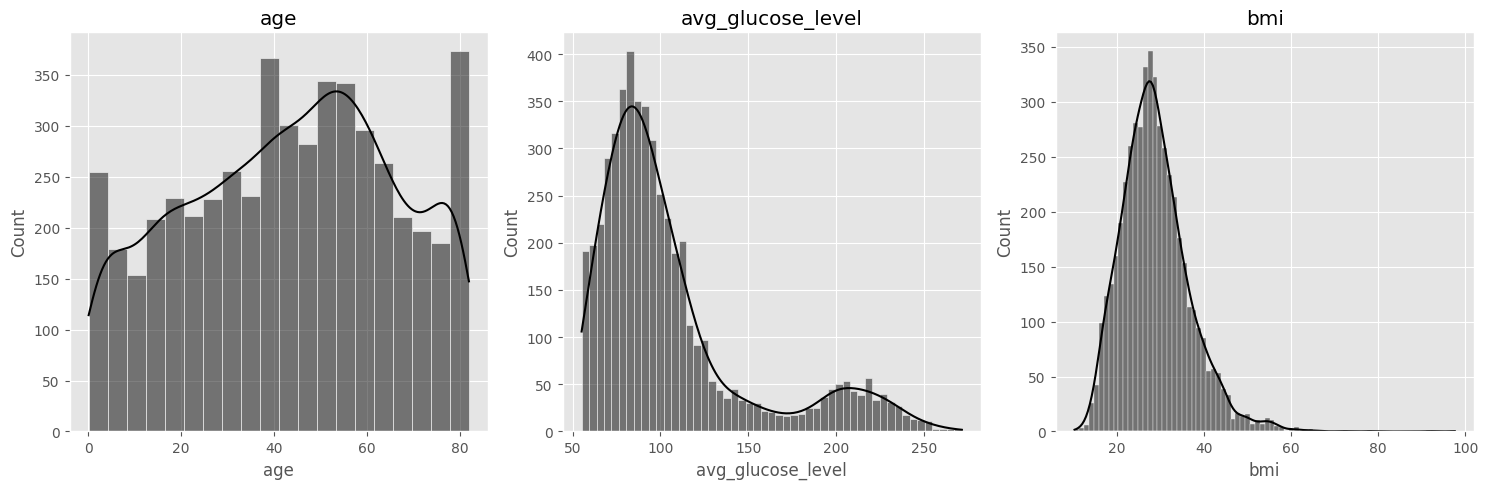

In [6]:
plt.style.use('ggplot')

plots = ['age', 'avg_glucose_level', 'bmi']

plt.figure(figsize=(15, 5))  # Adjust figsize to fit all plots comfortably

for i, column in enumerate(plots):
    plt.subplot(1, 3, i+1)
    sns.histplot(data[column], color='black', bins='auto', kde=True)
    plt.title(column)
    plt.grid(True)

plt.tight_layout()  
plt.show()


**The distribution of values of avg-glucose_level is not a normal distribution**

**avg_glucose_level seems to be skewed plus is multimodel distribution so MinMaxScaler and StandardScaler might not work here**

**No duplicate values in the data**

**For missing values in the BMI imputation, going to use  mean  value  for imputation as the distribution of the bmi data seems to be a normal distribution**

In [7]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

In [8]:
#1st impute/fill the missing values
#only BMI has missing values 
imputer = SimpleImputer(strategy = 'mean')
data['bmi']=imputer.fit_transform(data[['bmi']])
encoded_data= data.copy()
#2nd Scale down the numerical features
features_to_scale=['age','bmi']
scaler = MinMaxScaler()
encoded_data[features_to_scale]=scaler.fit_transform(encoded_data[features_to_scale])

In [9]:
#as the 'avg glucose level dosent have a normal distribution hence i am usign QuantileTransformer here 
from sklearn.preprocessing import QuantileTransformer

# Initialize QuantileTransformer
scaler = QuantileTransformer(output_distribution='uniform')

# Apply quantile transformation to avg_glucose_level
encoded_data['avg_glucose_level'] = scaler.fit_transform(encoded_data[['avg_glucose_level']])


In [10]:
df = encoded_data.copy()
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [11]:
# List of columns to one-hot encode
columns_to_encode = ['Residence_type', 'work_type', 'smoking_status','ever_married','gender']

# Iterate through each column and apply pd.get_dummies
for column in columns_to_encode:
    encoded_column = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df, encoded_column], axis=1)
    df = df.drop(columns=[column],axis=1)

# Convert boolean to integers
df = df.astype(int)


In [12]:
df.drop('id',axis=1,inplace=True)

**The data now has around 23 features **

**The dataframe 'df' now has clean data**

In [13]:
df.drop(['Residence_type_Rural','work_type_Private','smoking_status_Unknown', 'smoking_status_formerly smoked',
         'ever_married_Yes', 'gender_Male'], axis=1, inplace=True)

In [14]:
df.columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke', 'Residence_type_Urban', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Self-employed',
       'work_type_children', 'smoking_status_never smoked',
       'smoking_status_smokes', 'ever_married_No', 'gender_Female',
       'gender_Other'],
      dtype='object')

# Data Split

In [15]:
X = df.drop('stroke',axis=1)
y = df['stroke']
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size = 0.2,random_state=42) 


# Model Selection

**Train Logistic Regression Classifier**

In [16]:
# Instantiate Logistic Regression model
logreg = LogisticRegression()

# Train the model
logreg.fit(X_train, y_train)


LogisticRegression()

Predict the model output

In [17]:

# Predict on validation set
y_pred = logreg.predict(X_valid)

# Calculate accuracy
accuracy = accuracy_score(y_valid, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9393346379647749


# Model Training and Hyperparameter Tuning

In [18]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from xgboost import XGBClassifier
# from sklearn.model_selection import GridSearchCV

# # Initialize models
# xgb = XGBClassifier()
# rf = RandomForestClassifier()
# lr = LogisticRegression()

# # Define parameter grid
# param_grid_xgb = {'n_estimators': [100, 200], 'max_depth': [3, 6, 9]}
# param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [3, 6, 9]}
# param_grid_lr = {'C': [0.1, 1, 10]}

# # Grid search
# grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5)
# grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5)
# grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=5)

# # Fit models
# grid_search_xgb.fit(X_train, y_train)
# grid_search_rf.fit(X_train, y_train)
# grid_search_lr.fit(X_train, y_train)


#  Model Evaluation

In [19]:
# from sklearn.metrics import accuracy_score

# # Evaluate models
# y_pred_xgb = grid_search_xgb.predict(X_valid)
# y_pred_rf = grid_search_rf.predict(X_valid)
# y_pred_lr = grid_search_lr.predict(X_valid)

# print(f'XGBoost Accuracy: {accuracy_score(y_valid, y_pred_xgb)}')
# print(f'Random Forest Accuracy: {accuracy_score(y_valid, y_pred_rf)}')
# print(f'Logistic Regression Accuracy: {accuracy_score(y_valid, y_pred_lr)}')


In [26]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import mlflow
import mlflow.sklearn
import psutil
import time  # For time-based metrics

# Start MLflow experiment
mlflow.set_experiment("Healthcare_Model_Experiment")

try:
    with mlflow.start_run() as run:
        # Record start time
        start_time = time.time()
        mlflow.log_param("start_time", time.strftime("%Y-%m-%d %H:%M:%S"))

        # Log system metrics before training
        cpu_start = psutil.cpu_percent(interval=None)
        memory_start = psutil.virtual_memory().percent
        mlflow.log_metric("CPU_Usage_Start Before train", cpu_start)
        mlflow.log_metric("Memory_Usage_Start Before train", memory_start)
        
        # Initialize models
        xgb_model = XGBClassifier()
        rf_model= RandomForestClassifier()
        lr_model = LogisticRegression()

        mlflow.sklearn.log_model(xgb_model, "xgb_model")
        mlflow.sklearn.log_model(rf_model, "rf_model")
        mlflow.sklearn.log_model(lr_model, "lr_model")

        # Register the models
        # model_uri = "runs:/{}/model".format(run.info.run_id)
        # result = mlflow.register_model(model_uri, "MyModelName")

        # Log xgboost model
        mlflow.sklearn.log_model(xgb_model, "xgb_model")
        xgb_model_uri = f"runs:/{run.info.run_id}/xgb_model"
        xgb_result = mlflow.register_model(xgb_model_uri, "xgboostModel")
        print(f"xgboost model registered with name: {xgb_result.name}")
        print(f"xgboost model version: {xgb_result.version}")

        # Log RandomForest model
        mlflow.sklearn.log_model(rf_model, "rf_model")
        rf_model_uri = f"runs:/{run.info.run_id}/rf_model"
        rf_result = mlflow.register_model(rf_model_uri, "RandomForestModel")
        print(f"RandomForest model registered with name: {rf_result.name}")
        print(f"RandomForest model version: {rf_result.version}")
        
        # Log Logisticregression model
        mlflow.sklearn.log_model(lr_model, "lr_model")
        lr_model_uri = f"runs:/{run.info.run_id}/lr_model"
        lr_result = mlflow.register_model(lr_model_uri, "Logisticregression")
        print(f"Logisticregression model registered with name: {lr_result.name}")
        print(f"Logisticregression model version: {lr_result.version}")

        # Define parameter grid
        param_grid_xgb = {'n_estimators': [100, 200], 'max_depth': [3, 6, 9]}
        param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [3, 6, 9]}
        param_grid_lr = {'C': [0.1, 1, 10]}

        # Grid search
        grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5)
        grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5)
        grid_search_lr = GridSearchCV(lr_model, param_grid_lr, cv=5)

        # Fit models
        grid_search_xgb.fit(X_train, y_train)
        grid_search_rf.fit(X_train, y_train)
        grid_search_lr.fit(X_train, y_train)
        
        # Evaluate models
        y_pred_xgb = grid_search_xgb.predict(X_valid)
        y_pred_rf = grid_search_rf.predict(X_valid)
        y_pred_lr = grid_search_lr.predict(X_valid)

        xgb_accuracy = accuracy_score(y_valid, y_pred_xgb)
        rf_accuracy = accuracy_score(y_valid, y_pred_rf)
        lr_accuracy = accuracy_score(y_valid, y_pred_lr)

        print(f'XGBoost Accuracy: {xgb_accuracy}')
        mlflow.log_metric("XGBoost_Accuracy", xgb_accuracy)
        
        print(f'Random Forest Accuracy: {rf_accuracy}')
        mlflow.log_metric("Random_Forest_Accuracy", rf_accuracy)
        
        print(f'Logistic Regression Accuracy: {lr_accuracy}')
        mlflow.log_metric("Logistic_Regression_Accuracy", lr_accuracy)

        # Log models
        mlflow.sklearn.log_model(grid_search_xgb.best_estimator_, "xgboost_model")
        mlflow.sklearn.log_model(grid_search_rf.best_estimator_, "random_forest_model")
        mlflow.sklearn.log_model(grid_search_lr.best_estimator_, "logistic_regression_model")

        # Log system metrics after training
        cpu_end = psutil.cpu_percent(interval=None)
        memory_end = psutil.virtual_memory().percent
        mlflow.log_metric("CPU_Usage_End after train", cpu_end)
        mlflow.log_metric("Memory_Usage_End after train", memory_end)

        # Log duration of training
        duration = time.time() - start_time
        mlflow.log_metric("Training_Duration_Seconds", duration)

except Exception as e:
    print(f"Exception occurred: {e}")

finally:
    mlflow.end_run()  # Ensure the MLflow run is ended even if an exception occurs


2024/08/08 07:42:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/08 07:42:20 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/08 07:42:22 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
Registered model 'MyModelName' already exists. Creating a new version of this model...
Created version '2' of model 'MyModelName'.
2024/08/08 07:42:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/08 07:42:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/08 07:42:38

XGBoost Accuracy: 0.9324853228962818
Random Forest Accuracy: 0.9383561643835616
Logistic Regression Accuracy: 0.9393346379647749


2024/08/08 07:42:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/08 07:42:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/08 07:42:43 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


# Save the Best Model

In [21]:
import joblib

# Save the best model
best_model = grid_search_lr.best_estimator_
joblib.dump(best_model, 'best_model.pkl')


['best_model.pkl']

# MLflow Tracking

In [22]:
# import mlflow
# import mlflow.sklearn

# # Start MLflow run
# with mlflow.start_run():
#     mlflow.log_param('Model', 'lr')
#     mlflow.log_param('Best Params', grid_search_lr.best_params_)
#     mlflow.log_metric('Accuracy', accuracy_score(y_valid, y_pred_lr))
#     mlflow.sklearn.log_model(best_model, 'model')


In [23]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import mlflow
import mlflow.sklearn
import psutil
import time  # For time-based metrics

# Start MLflow experiment
mlflow.set_experiment("Healthcare_Model_Experiment")

try:
    with mlflow.start_run():
        # Record start time
        start_time = time.time()
        mlflow.log_param("start_time", time.strftime("%Y-%m-%d %H:%M:%S"))

        # Log system metrics before training
        cpu_start = psutil.cpu_percent(interval=None)
        memory_start = psutil.virtual_memory().percent
        mlflow.log_metric("CPU_Usage_Start", cpu_start)
        mlflow.log_metric("Memory_Usage_Start", memory_start)
        
        # Initialize models
        xgb = XGBClassifier()
        rf = RandomForestClassifier()
        lr = LogisticRegression()

        # Define parameter grid
        param_grid_xgb = {'n_estimators': [100, 200], 'max_depth': [3, 6, 9]}
        param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [3, 6, 9]}
        param_grid_lr = {'C': [0.1, 1, 10]}

        # Grid search
        grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5)
        grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5)
        grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=5)

        # Fit models
        grid_search_xgb.fit(X_train, y_train)
        grid_search_rf.fit(X_train, y_train)
        grid_search_lr.fit(X_train, y_train)
        
        # Register models
        xgb_model_path = "models/xgb_model"
        rf_model_path = "models/rf_model"
        lr_model_path = "models/lr_model"
        
        mlflow.sklearn.log_model(grid_search_xgb.best_estimator_, xgb_model_path)
        mlflow.sklearn.log_model(grid_search_rf.best_estimator_, rf_model_path)
        mlflow.sklearn.log_model(grid_search_lr.best_estimator_, lr_model_path)
        
        # Evaluate models
        y_pred_xgb = grid_search_xgb.predict(X_valid)
        y_pred_rf = grid_search_rf.predict(X_valid)
        y_pred_lr = grid_search_lr.predict(X_valid)

        xgb_accuracy = accuracy_score(y_valid, y_pred_xgb)
        rf_accuracy = accuracy_score(y_valid, y_pred_rf)
        lr_accuracy = accuracy_score(y_valid, y_pred_lr)

        print(f'XGBoost Accuracy: {xgb_accuracy}')
        mlflow.log_metric("XGBoost_Accuracy", xgb_accuracy)
        
        print(f'Random Forest Accuracy: {rf_accuracy}')
        mlflow.log_metric("Random_Forest_Accuracy", rf_accuracy)
        
        print(f'Logistic Regression Accuracy: {lr_accuracy}')
        mlflow.log_metric("Logistic_Regression_Accuracy", lr_accuracy)

        # Log models
        mlflow.sklearn.log_model(grid_search_xgb.best_estimator_, "xgboost_model")
        mlflow.sklearn.log_model(grid_search_rf.best_estimator_, "random_forest_model")
        mlflow.sklearn.log_model(grid_search_lr.best_estimator_, "logistic_regression_model")

        # Log system metrics after training
        cpu_end = psutil.cpu_percent(interval=None)
        memory_end = psutil.virtual_memory().percent
        mlflow.log_metric("CPU_Usage_End", cpu_end)
        mlflow.log_metric("Memory_Usage_End", memory_end)

        # Log duration of training
        duration = time.time() - start_time
        mlflow.log_metric("Training_Duration_Seconds", duration)

except Exception as e:
    print(f"Exception occurred: {e}")

finally:
    mlflow.end_run()  # Ensure the MLflow run is ended even if an exception occurs


2024/08/08 07:20:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/08 07:20:23 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/08 07:20:25 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


XGBoost Accuracy: 0.9324853228962818
Random Forest Accuracy: 0.9383561643835616
Logistic Regression Accuracy: 0.9393346379647749


2024/08/08 07:20:27 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/08 07:20:28 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/08 07:20:30 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [24]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import mlflow
import mlflow.sklearn
import psutil
import time
import psycopg2

# Database connection settings
DB_SETTINGS = {
    "dbname": "metrics_db",
    "user": "your_user",
    "password": "your_password",
    "host": "localhost",
    "port": 5432
}

# Function to push metrics to PostgreSQL
def push_metrics_to_db(metric_name, metric_value):
    conn = psycopg2.connect(**DB_SETTINGS)
    cur = conn.cursor()
    cur.execute("INSERT INTO metrics (metric_name, metric_value) VALUES (%s, %s);", (metric_name, metric_value))
    conn.commit()
    cur.close()
    conn.close()

# Function to train and evaluate models
def train_and_evaluate_models(X_train, y_train, X_valid, y_valid):
    # Initialize models
    xgb = XGBClassifier()
    rf = RandomForestClassifier()
    lr = LogisticRegression()

    # Define parameter grid
    param_grid_xgb = {'n_estimators': [100, 200], 'max_depth': [3, 6, 9]}
    param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [3, 6, 9]}
    param_grid_lr = {'C': [0.1, 1, 10]}

    # Grid search
    grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5)
    grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5)
    grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=5)

    # Fit models
    grid_search_xgb.fit(X_train, y_train)
    grid_search_rf.fit(X_train, y_train)
    grid_search_lr.fit(X_train, y_train)

    # Evaluate models
    y_pred_xgb = grid_search_xgb.predict(X_valid)
    y_pred_rf = grid_search_rf.predict(X_valid)
    y_pred_lr = grid_search_lr.predict(X_valid)

    xgb_accuracy = accuracy_score(y_valid, y_pred_xgb)
    rf_accuracy = accuracy_score(y_valid, y_pred_rf)
    lr_accuracy = accuracy_score(y_valid, y_pred_lr)

    return {
        "xgb_model": grid_search_xgb.best_estimator_,
        "rf_model": grid_search_rf.best_estimator_,
        "lr_model": grid_search_lr.best_estimator_,
        "xgb_accuracy": xgb_accuracy,
        "rf_accuracy": rf_accuracy,
        "lr_accuracy": lr_accuracy
    }

# Start MLflow experiment
mlflow.set_experiment("Healthcare_Model_Experiment")

try:
    # Record start time
    start_time = time.time()
    mlflow.log_param("start_time", time.strftime("%Y-%m-%d %H:%M:%S"))

    # Log system metrics before training
    cpu_start = psutil.cpu_percent(interval=None)
    memory_start = psutil.virtual_memory().percent
    push_metrics_to_db("CPU_Usage_Start", cpu_start)
    push_metrics_to_db("Memory_Usage_Start", memory_start)

    # Initial training and evaluation
    results = train_and_evaluate_models(X_train, y_train, X_valid, y_valid)

    # Log initial metrics
    print(f'Initial XGBoost Accuracy: {results["xgb_accuracy"]}')
    mlflow.log_metric("XGBoost_Accuracy", results["xgb_accuracy"])
    push_metrics_to_db("XGBoost_Accuracy", results["xgb_accuracy"])
    
    print(f'Initial Random Forest Accuracy: {results["rf_accuracy"]}')
    mlflow.log_metric("Random_Forest_Accuracy", results["rf_accuracy"])
    push_metrics_to_db("Random_Forest_Accuracy", results["rf_accuracy"])
    
    print(f'Initial Logistic Regression Accuracy: {results["lr_accuracy"]}')
    mlflow.log_metric("Logistic_Regression_Accuracy", results["lr_accuracy"])
    push_metrics_to_db("Logistic_Regression_Accuracy", results["lr_accuracy"])

    # Log models
    mlflow.sklearn.log_model(results["xgb_model"], "xgboost_model")
    mlflow.sklearn.log_model(results["rf_model"], "random_forest_model")
    mlflow.sklearn.log_model(results["lr_model"], "logistic_regression_model")

    # Example of a retrain mechanism
    # Set a threshold for improvement
    improvement_threshold = 0.01  # 1% improvement

    # Assume previous accuracy (for demonstration purposes, in a real scenario this would be loaded from previous runs)
    previous_xgb_accuracy = 0.90  # Example previous accuracy
    previous_rf_accuracy = 0.90
    previous_lr_accuracy = 0.90

    # Check if retraining is needed
    if results["xgb_accuracy"] > previous_xgb_accuracy + improvement_threshold:
        print("Retraining XGBoost model due to improved accuracy.")
        # Retrain or update XGBoost model as needed
        results["xgb_model"] = train_and_evaluate_models(X_train, y_train, X_valid, y_valid)["xgb_model"]

    if results["rf_accuracy"] > previous_rf_accuracy + improvement_threshold:
        print("Retraining Random Forest model due to improved accuracy.")
        # Retrain or update Random Forest model as needed
        results["rf_model"] = train_and_evaluate_models(X_train, y_train, X_valid, y_valid)["rf_model"]

    if results["lr_accuracy"] > previous_lr_accuracy + improvement_threshold:
        print("Retraining Logistic Regression model due to improved accuracy.")
        # Retrain or update Logistic Regression model as needed
        results["lr_model"] = train_and_evaluate_models(X_train, y_train, X_valid, y_valid)["lr_model"]

    # Log system metrics after training
    cpu_end = psutil.cpu_percent(interval=None)
    memory_end = psutil.virtual_memory().percent
    push_metrics_to_db("CPU_Usage_End", cpu_end)
    push_metrics_to_db("Memory_Usage_End", memory_end)

    # Log duration of training
    duration = time.time() - start_time
    mlflow.log_metric("Training_Duration_Seconds", duration)
    push_metrics_to_db("Training_Duration_Seconds", duration)

except Exception as e:
    print(f"Exception occurred: {e}")

finally:
    mlflow.end_run()  # Ensure the MLflow run is ended even if an exception occurs


Exception occurred: connection to server at "localhost" (::1), port 5432 failed: Connection refused
	Is the server running on that host and accepting TCP/IP connections?
connection to server at "localhost" (127.0.0.1), port 5432 failed: Connection refused
	Is the server running on that host and accepting TCP/IP connections?

